In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import gc
import os

# tiff file i/o
import tifffile
from pyometiff import OMETIFFReader
from pyometiff import OMETIFFWriter


In [2]:
file_name = 'RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff'

In [3]:
# # Load image data (into memory)
# img = imread("data/" + file_name)

In [4]:
# Read OME TIFF file using pyometiff 
reader = OMETIFFReader(fpath="data/" + file_name)

img, metadata, xml_metadata = reader.read()

del reader

Key not found: 'NoneType' object has no attribute 'iter'
key not found 'NoneType' object has no attribute 'iter'


In [5]:
# # view 1 image
# #img = io.imread(files[-1])
# plt.figure(figsize=(2,2))
# plt.imshow(imgs[0])
# plt.axis('off')
# plt.show()

In [6]:
img.shape

(7, 87840, 36480)

In [7]:
# plt.imshow(imgs[0][3,2000:3000,2000:3000])
# plt.show()

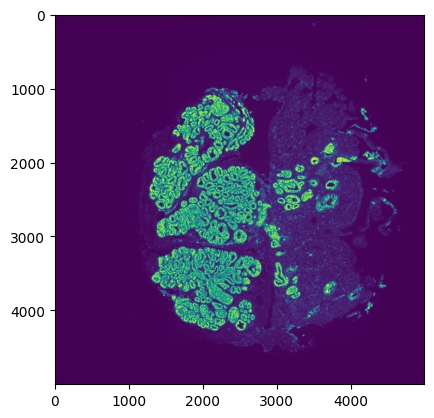

In [8]:
# Render parts of iamge to ensure that it has been loaded
channel = 2
plt.imshow(img[channel, 10000:15000, 10000:15000])
plt.show()

In [9]:
# smoothing kernel of autoflourescence
autoflour_average = cv2.blur(img[6, :, :], (3, 3))

In [10]:
# Subtract autoflourescence channel, avoiding clipping by integer overflow
autoflour_factor = 1.5
dapi_corrected = img[0, :, :] - np.minimum(autoflour_factor * autoflour_average, img[0, :, :])

Text(0.5, 1.0, 'DAPI - 1.5 * AF')

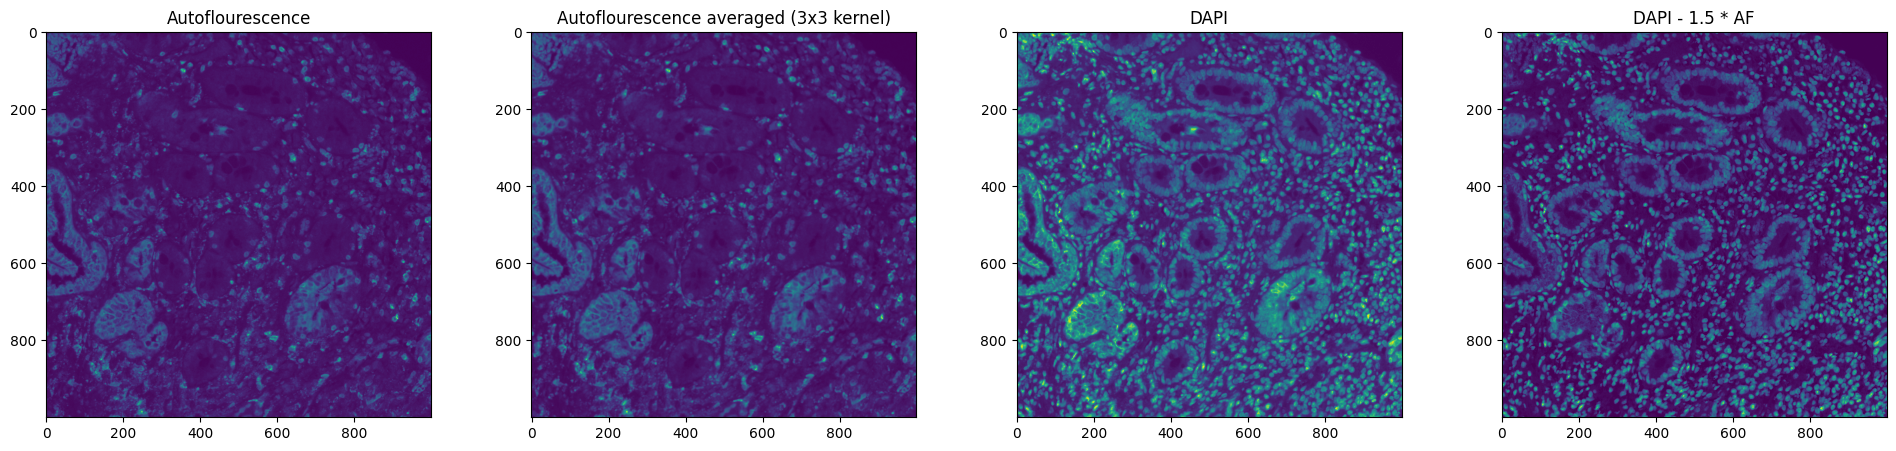

In [11]:
# Original autoflourescence channel
#x_view = slice(13500, 14000)
#y_view = slice(13500, 14000)

x_view = slice(13000, 14000)
y_view = slice(13000, 14000)

plt.rcParams['figure.figsize'] = [24, 5]

fig, axs = plt.subplots(1, 4)

#plt.imshow(imgs[0][6, x_view, y_view])
axs[0].imshow(img[6, x_view, y_view])
axs[0].set_title("Autoflourescence")

# Averaged
axs[1].imshow(autoflour_average[x_view, y_view])
axs[1].set_title("Autoflourescence averaged (3x3 kernel)")

# Corresponding DAPI
axs[2].imshow(img[0, x_view, y_view], )
axs[2].set_title("DAPI")

axs[3].imshow(dapi_corrected[x_view, y_view], )
axs[3].set_title(f"DAPI - {autoflour_factor} * AF")


In [12]:
# Memory management of temporary variables
del dapi_corrected

In [13]:
# Compute max projection of T cell cytoplasm markers, before adjustment
# this variable is overwritten later in the script
im_max = np.max(img[[1, 3, 4, 5], :, :], axis=0)


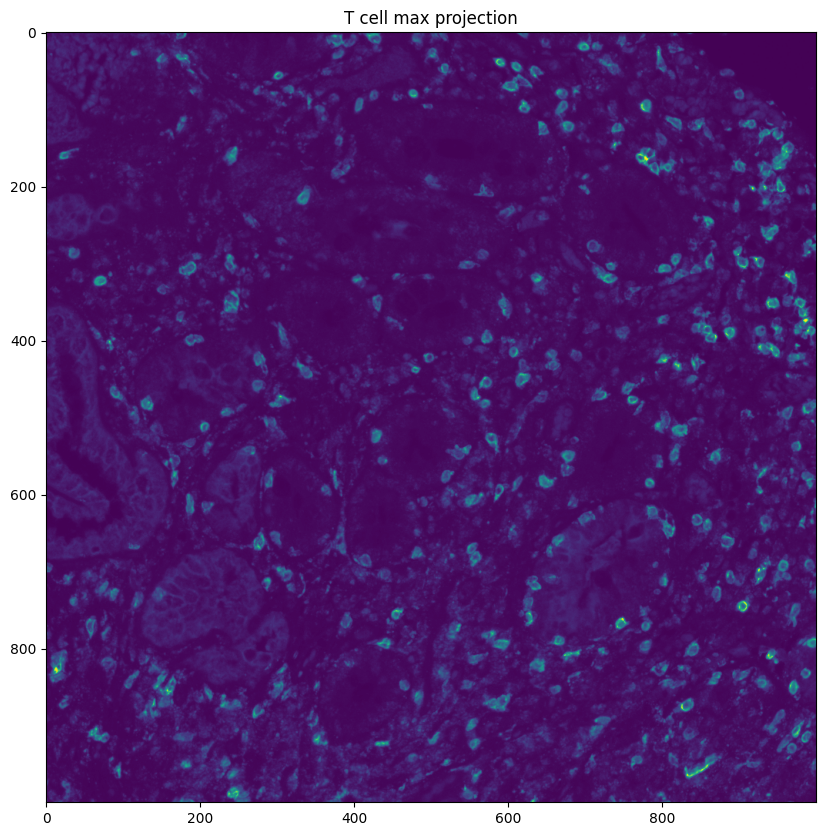

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(im_max[x_view, y_view])
plt.title("T cell max projection")
plt.show()

In [15]:
# Adjust images for autoflourescence in place
# WARNING: this will overwrite data used as input for calculations done above.

#autoflour_factors = [1.5, 0.5, 1, 0.5, 1, 0.5]  # v2
#autoflour_factors = [1.5, 0.5, 1, 0.5, 0.5, 0.5]  # v3

autoflour_factors = [1.5, 0.5, 1, 0.25, 0.25, 0.25]  # v1

for k in range(6):
    gc.collect()
    # 0 to 5
    img[k, :, :] = img[k, :, :] - np.minimum(autoflour_factors[k] * autoflour_average, img[k, :, :])


In [16]:
img.shape

(7, 87840, 36480)

In [17]:
# Compute max projection of T cell cytoplasm markers
im_max = np.max(img[[1, 3, 4, 5], :, :], axis=0)


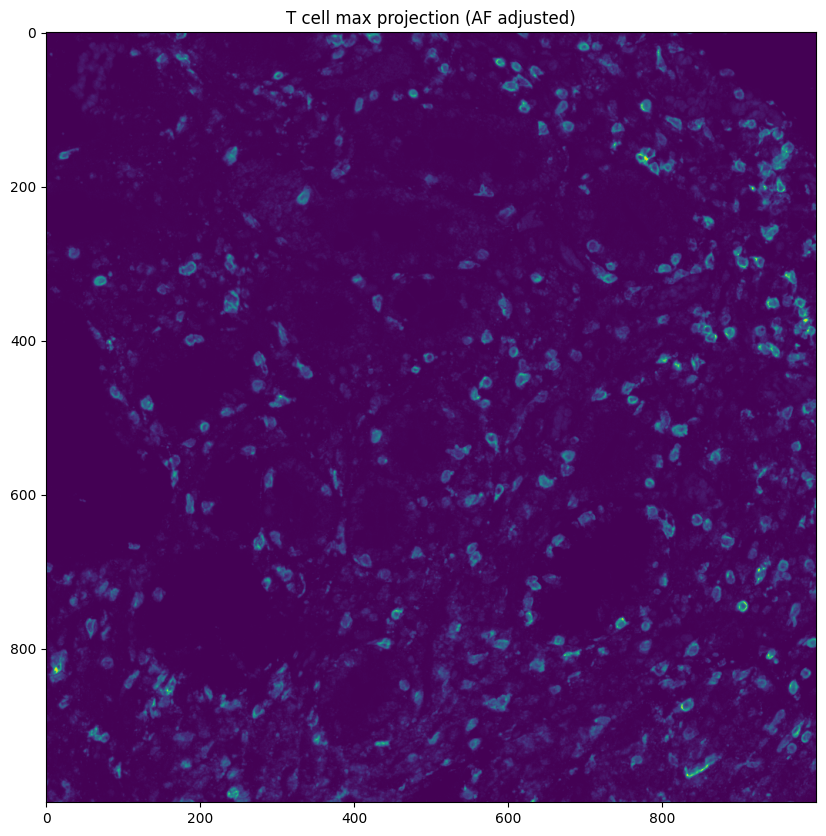

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(im_max[x_view, y_view])
plt.title("T cell max projection (AF adjusted)")
plt.show()

In [19]:
# Append T cell max projection channel
img = np.append(img, im_max[None, :, :], axis=0)

In [20]:
metadata

{'Directory': 'data',
 'Filename': 'RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff',
 'Extension': 'ome.tiff',
 'ImageType': 'ometiff',
 'TotalSeries': 4,
 'SizeX': 36480,
 'SizeY': 87840,
 'SizeZ': 1,
 'SizeC': 7,
 'SizeT': 1,
 'SizeS': 1,
 'SizeB': 1,
 'SizeM': 1,
 'PhysicalSizeX': 0.4983437248734626,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.4983437248734626,
 'PhysicalSizeYUnit': 'µm',
 'Sizes BF': [4, 1, 1, 7, 87840, 36480],
 'DimOrder BF': 'XYZCT',
 'DimOrder BF Array': 'TCZYX',
 'ObjMag': '10.0',
 'ObjID': 'Objective:0:0',
 'InstrumentID': 'Instrument:0',
 'Channels': {'DAPI': {'Name': 'DAPI',
   'ID': 'Channel:0:0',
   'SamplesPerPixel': 1,
   'Color': '65535'},
  'Opal 570': {'Name': 'Opal 570',
   'ID': 'Channel:0:1',
   'SamplesPerPixel': 1,
   'Color': '-65281'},
  'Opal 690': {'Name': 'Opal 690',
   'ID': 'Channel:0:2',
   'SamplesPerPixel': 1,
   'Color': '-16776961'},
  'Opal 480': {'Name': 'Opal 480',
   'ID': 'Channel:0:3',
   'Samples

In [21]:
# Add new corresponding metadata for added channel
metadata_new = metadata

metadata_new['SizeC'] = metadata['SizeC'] + 1

metadata_new['Channels']['Max project'] = {
    'Name': 'T cell max project',
    'ID': 'Channel:0:7',
    'SamplesPerPixel': 1,
    'Color': '255'
}

In [22]:
# Copy specified fields in metadata dict 
metadata_new_subset = {
    key: metadata_new[key] for key in [
        'Channels', 'SizeC','PhysicalSizeX', 'PhysicalSizeXUnit', 'PhysicalSizeY', 'PhysicalSizeYUnit'
    ]
}

In [23]:
os.makedirs("data/adjust", exist_ok=True)

In [24]:
img.shape

(8, 87840, 36480)

In [25]:
metadata_new_subset

{'Channels': {'DAPI': {'Name': 'DAPI',
   'ID': 'Channel:0:0',
   'SamplesPerPixel': 1,
   'Color': '65535'},
  'Opal 570': {'Name': 'Opal 570',
   'ID': 'Channel:0:1',
   'SamplesPerPixel': 1,
   'Color': '-65281'},
  'Opal 690': {'Name': 'Opal 690',
   'ID': 'Channel:0:2',
   'SamplesPerPixel': 1,
   'Color': '-16776961'},
  'Opal 480': {'Name': 'Opal 480',
   'ID': 'Channel:0:3',
   'SamplesPerPixel': 1,
   'Color': '16777215'},
  'Opal 620': {'Name': 'Opal 620',
   'ID': 'Channel:0:4',
   'SamplesPerPixel': 1,
   'Color': '-8388353'},
  'Opal 520': {'Name': 'Opal 520',
   'ID': 'Channel:0:5',
   'SamplesPerPixel': 1,
   'Color': '16711935'},
  'Sample AF': {'Name': 'Sample AF',
   'ID': 'Channel:0:6',
   'SamplesPerPixel': 1,
   'Color': '255'},
  'Max project': {'Name': 'T cell max project',
   'ID': 'Channel:0:7',
   'SamplesPerPixel': 1,
   'Color': '255'}},
 'SizeC': 8,
 'PhysicalSizeX': 0.4983437248734626,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.4983437248734626,
 'Phy

In [26]:
# Write file as pyrimidal tiff for reading with QuPath
# Adopted from https://gist.github.com/bpavie/8d97f753c4d83860bcffca7da230e9a0
# And tifffile author guidance at:
# https://forum.image.sc/t/creating-a-multi-channel-pyramid-ome-tiff-with-tiffwriter-in-python/76424/3

from tifffile import TiffWriter

image = img  # copy image object which is downsampled during writing

# get image dimensions
channels, height, width = image.shape

# transpose dimensions such that cv2.resize works implicitly on multiple channels
image = image.transpose((1, 2, 0))  # height x width x channels

# Number of pyramidal renders 
subifds = 8

# Get pixel dimension from metadata
umPerPix = (metadata['PhysicalSizeX'], metadata['PhysicalSizeY'])

with TiffWriter("data/adjust/" + file_name, bigtiff=True, ome=True) as tif:
    for level in range(subifds + 1):  # pyramid rendering levels, first iteration declares number of expected subifds
        print("level:", level, ", width:", width, ", height:", height)
        tif.write(
            image.transpose((2, 0, 1)),  # reshapes written data back into channels x height x width
            software='Glencoe/Faas pyramid',
            metadata=metadata_new_subset,
            resolution = [10000/umPerPix[0]/2**level, 10000/umPerPix[1]/2**level, 'CENTIMETER'],
            compression='zlib',
            # Logic handling pyramidal renders
            subifds=subifds if level == 0 else None,  # opens a branch in the IFD tree, which is closed (going back to the main IFD chain) after n SubIFDs have been written
            subfiletype=1 if level else 0,
        )
        
        # Downsample image resolution
        width //= 2
        height //= 2
        image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

level: 0 , width: 36480 , height: 87840
level: 1 , width: 18240 , height: 43920
level: 2 , width: 9120 , height: 21960
level: 3 , width: 4560 , height: 10980
level: 4 , width: 2280 , height: 5490
level: 5 , width: 1140 , height: 2745
level: 6 , width: 570 , height: 1372
level: 7 , width: 285 , height: 686
level: 8 , width: 142 , height: 343


In [27]:
# from tifffile import TiffWriter

# with TiffWriter("data/adjust/" + file_name, bigtiff=True, ome=True) as tif:
#     tif.write(
#         img,
#         photometric='minisblack',
#         tile=(256, 256),
#         compression='zlib',
#         #resolutionunit='CENTIMETER',
#         #resolution=(1e4 / pixelsize, 1e4 / pixelsize),
#         metadata=metadata,
#     )


In [28]:
# # Write image array as tiff file with OME metadata
# # Image is not pyramidal and is too large to be loaded into QuPath 0.5
# writer = OMETIFFWriter(
#     fpath="data/adjust/" + file_name,
#     array=img,
#     metadata=metadata_new,
#     compression='zlib',
#     bigtiff=True,
#     explicit_tiffdata=False)

# writer.write()

In [29]:
# write data with tifffile library
# Does not include OME metadata
#tifffile.imwrite("data/adjust/" + file_name, img,  compression='zlib', ome=True, bigtiff=True)
#tifffile.imwrite("data/adjust/" + file_name, img,  compression='zlib')

In [30]:
#cv.imwrite("data/adjust/test.tiff", im_max)

In [31]:
#cv.imwrite("data/adjust/test.tiff", img)

In [32]:
# # Sourced from:
# # https://github.com/FrancisCrickInstitute/OmeSliCC/blob/99ae3115ccbca34902298c9e6a2753010a811c2d/src/conversion.py#L220
# def save_tiff(filename: str, image: np.ndarray, metadata: dict = None, xml_metadata: str = None,
#               resolution: tuple = None, resolution_unit: str = None, tile_size: tuple = None, compression: [] = None,
#               combine_channels=True, npyramid_add: int = 0, pyramid_downsample: float = 4.0, pyramid_sizes_add: list = None):
#     # Use tiled writing (less memory needed but maybe slower):
#     # writer.write(tile_iterator, shape=shape_size_at_desired_mag_pyramid_scale, tile=tile_size)

#     #data = ensure_signed_image(data)   # * Compression JPEGXR_NDPI does not support signed types

#     nchannels = image.shape[2] if len(image.shape) > 2 else 1
#     split_channels = (nchannels > 1 and not combine_channels)
#     photometric = 'minisblack' if split_channels else None
#     width, height = image.shape[1], image.shape[0]
#     scale = 1
#     if resolution is not None:
#         resolution = tuple(resolution[0:2])
#     if pyramid_sizes_add is not None:
#         npyramid_add = len(pyramid_sizes_add)
#     xml_metadata_bytes = xml_metadata.encode() if xml_metadata is not None else None
#     bigtiff = (image.size * image.itemsize > 2 ** 32)       # estimate size (w/o compression or pyramid)
#     with TiffWriter(filename, ome=False, bigtiff=bigtiff) as writer:    # set ome=False to provide custom OME xml in description
#         writer.write(reverse_color_axis(image, reverse=split_channels), photometric=photometric, subifds=npyramid_add,
#                      resolution=resolution, resolutionunit=resolution_unit, tile=tile_size, compression=compression,
#                      metadata=metadata, description=xml_metadata_bytes)

#         for i in range(npyramid_add):
#             if pyramid_sizes_add is not None:
#                 new_width, new_height = pyramid_sizes_add[i]
#             else:
#                 scale /= pyramid_downsample
#                 if resolution is not None:
#                     resolution = tuple(np.divide(resolution, pyramid_downsample))
#                 new_width, new_height = np.int0(np.round(np.multiply([width, height], scale)))
#             image = image_resize(image, (new_width, new_height))
#             writer.write(reverse_color_axis(image, reverse=split_channels), photometric=photometric, subfiletype=1,
#                          resolution=resolution, resolutionunit=resolution_unit, tile=tile_size, compression=compression)

In [33]:
#save_tiff("data/adjust/" + file_name, img, npyramid_add=8)

In [34]:
# # Write file as pyrimidal tiff for reading with QuPath
# # Adopted from https://gist.github.com/bpavie/8d97f753c4d83860bcffca7da230e9a0
# # And tifffile author guidance at:
# # https://forum.image.sc/t/creating-a-multi-channel-pyramid-ome-tiff-with-tiffwriter-in-python/76424/3

# from tifffile import TiffWriter

# image = img

# # get image dimensions
# channels, height, width = image.shape

# subifds = 5

# # transpose dimensions such that cv2.resize works implicitly on multiple channels
# image = image.transpose((1, 2, 0))  # height x width x channels

# #Pixel size in um
# #umPerPix = (0.12, 0.12)

# # Get pixel dimension from metadata
# umPerPix = (metadata['PhysicalSizeX'], metadata['PhysicalSizeY'])

# with TiffWriter("data/adjust/" + file_name, bigtiff=True, ome=True) as tif:   
#     tif.write(image.transpose((2, 0, 1)),
#         subifds=subifds,  # opens a branch in the IFD tree, which is closed (going back to the main IFD chain) after n SubIFDs have been written
#         metadata=False,  # do not write tifffile metadata
#         #tile=(256, 256),
#         photometric='minisblack',
#         compression='zlib',
#         resolution=[10000/umPerPix[0], 10000/umPerPix[1], 'CENTIMETER']
#     )
    
#     for level in range(subifds):
#         width //= 2
#         height //= 2
#         image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_LINEAR)
#         tif.write(
#             image.transpose((2, 0, 1)),
#             subfiletype=1,
#             metadata=False,
#             #tile=(256, 256),
#             photometric='minisblack',
#             compression='zlib',
#             resolution = [10000/umPerPix[0]/2**(level + 1), 10000/umPerPix[1]/2**(level + 1), 'CENTIMETER']
#         )

In [35]:
# # Write file as pyrimidal tiff for reading with QuPath
# # Adopted from https://gist.github.com/bpavie/8d97f753c4d83860bcffca7da230e9a0
# # And tifffile author guidance at:
# # https://forum.image.sc/t/creating-a-multi-channel-pyramid-ome-tiff-with-tiffwriter-in-python/76424/3

# from tifffile import TiffWriter

# image = img

# # get image dimensions
# channels, height, width = image.shape

# # transpose dimensions such that cv2.resize works implicitly on multiple channels
# image = image.transpose((1, 2, 0))  # height x width x channels

# #Pixel size in um
# #umPerPix = (0.12, 0.12)

# # Get pixel dimension from metadata
# umPerPix = (metadata['PhysicalSizeX'], metadata['PhysicalSizeY'])

# with TiffWriter("data/adjust/" + file_name, bigtiff=True, ome=True) as tif:
#     level = 0
#     while True:
#         print("level:", level, ", width:", width, ", height:", height)
#         tif.write(
#             #image,
#             image.transpose((2, 0, 1)),  # reshapes written data back into channels x height x width
#             software='Glencoe/Faas pyramid',
#             metadata=None,
#             #tile=(256, 256),
#             resolution = [10000/umPerPix[0]/2**level, 10000/umPerPix[1]/2**level, 'CENTIMETER'],
#             #metadata={'spacing': 0.12, 'unit': 'um'},
#             #compress=1,  # low level deflate, Looks to not work with QuPath/bioformat
#             #compress=('jpeg', 95),  # requires imagecodecs, Looks to not work with QuPath/bioformat
#             compression='zlib',
#             subfiletype=1 if level else 0,
#             sub
        
#         )
#         if max(width, height) < 256:
#             break
#         level += 1
#         width //= 2
#         height //= 2
#         image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_LINEAR)